In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import sys
sys.path.append("../")
import preproc as preproc
import models as models
import analysis as ana

Duplicate key in file '/Users/fu.j/.matplotlib/matplotlibrc', line 2 ('backend: TkAgg')


# Data reading

In [2]:
# Normalized DMS data and DeMaSk features. Keep 'NA' in wt_mut.
norm_dms_demask = pd.read_csv('../data/normalized/normalized_dms_DeMaSk_features.csv', 
                              index_col=0, na_values=[''], keep_default_na=False)
norm_as = pd.read_csv('../data/normalized/normalized_alanine_scanning.csv')

# Protein property features (alanine scanning feature is not included).
demask_features = ['entropy', 'log2f_var', 'matrix']

In [171]:
data_info = pd.read_csv('../data/data_info/dataset_info.csv', index_col=0)

# Modelling

## Model with all alanine scanning (AS) data

In [158]:
all_as = norm_as.copy()
# Merge in a cartesian product way.
dms_all_as = pd.merge(norm_dms_demask, all_as[['uniprot_id', 'u_pos', 'Ascan_id', 'AS_score']], 
                      on=['uniprot_id', 'u_pos'], how='left')

# Identifier for each DMS+AS combined dataset.
dms_all_as['dmsa_id'] = dms_all_as['dms_id'] + '@' + dms_all_as['Ascan_id'].astype(str)
dms_all_as['Ascan_score_avail'] = ~dms_all_as['AS_score'].isna()

In [159]:
# Impute alanine scanning scores by mean and encode wild-type & mutation type amino acids.
dms_all_as, encoded_col = preproc.impute_encode_features(dms_all_as, ['aa1', 'aa2'], ['AS_score'], ['aa1', 'aa2'])
dms_all_as[encoded_col] = dms_all_as[encoded_col].mul(dms_all_as['AS_score'], axis='index')

# Weight each mutatnt.
weight = dms_all_as.groupby(['uniprot_id', 'u_pos', 'aa2'])['score'].count()
weight = 1 / weight
weight.name = 'weight'
dms_all_as = pd.merge(dms_all_as, weight, left_on=['uniprot_id', 'u_pos', 'aa2'], right_index=True,
                      how='outer', validate='m:1').reset_index(drop=True)

In [ ]:
for unip in dms_all_as['uniprot_id'].unique():  # Leave-one-protein-out cross-validation
    train_data = dms_all_as.query("uniprot_id != @unip")
    test_data = dms_all_as.query("uniprot_id == @unip")
    train_data, test_data = models.refit_matrix_score(train_data, test_data)
    
    for model in ['with_as', 'no_as']:
        output_header = f"../result/prediction/demask_based/all_as/{unip}_{model}_"
        if model == 'with_as':
            model_features = demask_features + encoded_col + ['AS_score']
        else:
            model_features = demask_features.copy()
            
        estimator = LinearRegression(n_jobs=1)
        predictor = estimator.fit(train_data[model_features], train_data['score'], train_data['weight'])
        models.save_compared_prediction(predictor, test_data, model_features, 'score', output_header)

## Model with manually picked AS subset

In [53]:
# Pick AS subset that are highly compatibility with given DMS assay.
manual_as_subset = data_info.query("assumed_compatibility == 'High'")[['dms_id', 'Ascan_id']]
manual_as = pd.merge(norm_as, manual_as_subset, on='Ascan_id', how='outer')
# Merge in a cartesian product way.
dms_manual_as = pd.merge(norm_dms_demask, manual_as[['dms_id', 'u_pos', 'Ascan_id', 'AS_score']],
                         on=['dms_id', 'u_pos'], how='left')

# Identifier for each DMS+AS combined dataset.
dms_manual_as['dmsa_id'] = dms_manual_as['dms_id'] + '@' + dms_manual_as['Ascan_id'].astype(str)
dms_manual_as['Ascan_score_avail'] = ~dms_manual_as['AS_score'].isna()

In [62]:
# Impute alanine scanning scores by mean and encode wild-type & mutation type amino acids.
dms_manual_as, encoded_col = preproc.impute_encode_features(dms_manual_as, ['aa1', 'aa2'], ['AS_score'], ['aa2'])
dms_manual_as[encoded_col] = dms_manual_as[encoded_col].mul(dms_manual_as['AS_score'], axis='index')

# Weight each mutatnt.
weight = dms_manual_as.groupby(['uniprot_id', 'u_pos', 'aa2'])['score'].count()
weight = 1 / weight
weight.name = 'weight'
dms_manual_as = pd.merge(dms_manual_as, weight, left_on=['uniprot_id', 'u_pos', 'aa2'], right_index=True,
                         how='outer', validate='m:1').reset_index(drop=True)

In [63]:
for unip in dms_manual_as['uniprot_id'].unique():  # Leave-one-protein-out cross-validation
    train_data = dms_manual_as.query("uniprot_id != @unip")
    test_data = dms_manual_as.query("uniprot_id == @unip")
    train_data, test_data = models.refit_matrix_score(train_data, test_data)
    
    for model in ['with_as', 'no_as']:
        output_header = f"../result/prediction/demask_based/manual_as/{unip}_{model}_"
        if model == 'with_as':
            model_features = demask_features + encoded_col + ['AS_score']
        else:
            model_features = demask_features.copy()
            
        estimator = LinearRegression(n_jobs=1)
        predictor = estimator.fit(train_data[model_features], train_data['score'], train_data['weight'])
        models.save_compared_prediction(predictor, test_data, model_features, 'score', output_header)

## Model with automatically picked AS subset

In [105]:
# Pick AS data with highest regularized correlation for DMS study.
automatic_as_subset = []
for index, df in data_info.groupby('dms_id', as_index=False):
    df = df.dropna().sort_values('regularized_correlation')
    if len(df) > 0:
        automatic_as_subset.append(df.iloc[-1][['dms_id', 'Ascan_id']])  # Pick data with largest regularized correlation.
automatic_as_subset = pd.DataFrame(automatic_as_subset)
automatic_as = pd.merge(norm_as, automatic_as_subset, on='Ascan_id', how='outer')
# Merge in a cartesian product way.
dms_automatic_as = pd.merge(norm_dms_demask, automatic_as[['dms_id', 'u_pos', 'Ascan_id', 'AS_score']],
                         on=['dms_id', 'u_pos'], how='left')

# Identifier for each DMS+AS combined dataset.
dms_automatic_as['dmsa_id'] = dms_automatic_as['dms_id'] + '@' + dms_automatic_as['Ascan_id'].astype(str)
dms_automatic_as['Ascan_score_avail'] = ~dms_automatic_as['AS_score'].isna()

In [106]:
# Impute alanine scanning scores by mean and encode wild-type & mutation type amino acids.
dms_automatic_as, encoded_col = preproc.impute_encode_features(dms_automatic_as, ['aa1', 'aa2'], ['AS_score'], ['aa2'])
dms_automatic_as[encoded_col] = dms_automatic_as[encoded_col].mul(dms_automatic_as['AS_score'], axis='index')

# Weight each mutatnt.
weight = dms_automatic_as.groupby(['uniprot_id', 'u_pos', 'aa2'])['score'].count()
weight = 1 / weight
weight.name = 'weight'
dms_automatic_as = pd.merge(dms_automatic_as, weight, left_on=['uniprot_id', 'u_pos', 'aa2'], right_index=True,
                         how='outer', validate='m:1').reset_index(drop=True)

In [108]:
for unip in dms_automatic_as['uniprot_id'].unique():  # Leave-one-protein-out cross-validation
    train_data = dms_automatic_as.query("uniprot_id != @unip")
    test_data = dms_automatic_as.query("uniprot_id == @unip")
    train_data, test_data = models.refit_matrix_score(train_data, test_data)
    
    for model in ['with_as', 'no_as']:
        output_header = f"../result/prediction/demask_based/automatic_as/{unip}_{model}_"
        if model == 'with_as':
            model_features = demask_features + encoded_col + ['AS_score']
        else:
            model_features = demask_features.copy()
            
        estimator = LinearRegression(n_jobs=1)
        predictor = estimator.fit(train_data[model_features], train_data['score'], train_data['weight'])
        models.save_compared_prediction(predictor, test_data, model_features, 'score', output_header)

# Performance

In [109]:
file_dir = {'All AS data': '../result/prediction/demask_based/all_as/',
            'Manually curated\nAS subset': '../result/prediction/demask_based/manual_as/',
            'Automatically curated\nAS subset': '../result/prediction/demask_based/automatic_as/'}
mut_prediction = dict()
for model in file_dir.keys():
    mut_prediction[model] = ana.combine_prediction_result(file_dir[model], 
                                                          norm_dms_demask['uniprot_id'].unique())
    
model_perform = pd.DataFrame()
for model in mut_prediction.keys():
    foo = ana.calculate_model_performance(mut_prediction[model])
    foo['model'] = model
    model_perform = model_perform.append(foo, ignore_index=True)
model_perform = pd.merge(model_perform, data_info, on='dmsa_id', how='left', validate='m:1')

In [129]:
if_one_residue = dms_all_as.groupby('dmsa_id')['u_pos'].nunique()
one_residue_filter = if_one_residue[if_one_residue == 1].index

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

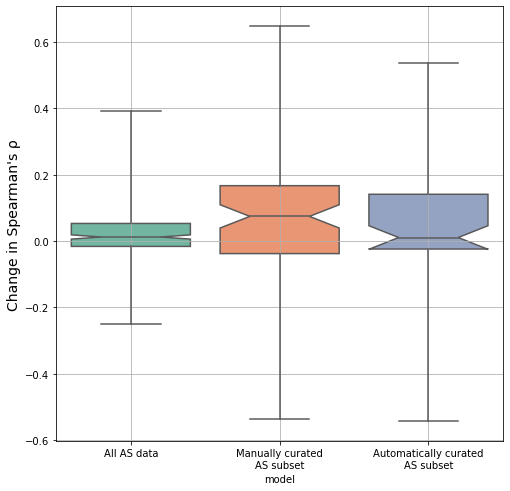

In [140]:
plt.figure(figsize=(8,8))
sns.boxplot(data=model_perform[~model_perform['Ascan_id'].isna()].query("dmsa_id not in @one_residue_filter"), 
            x='model', y='diff_spear', palette='Set2', notch=True, whis=np.inf)
plt.ylabel('Change in Spearman\'s ρ', fontsize=14)
plt.grid()
plt.show()

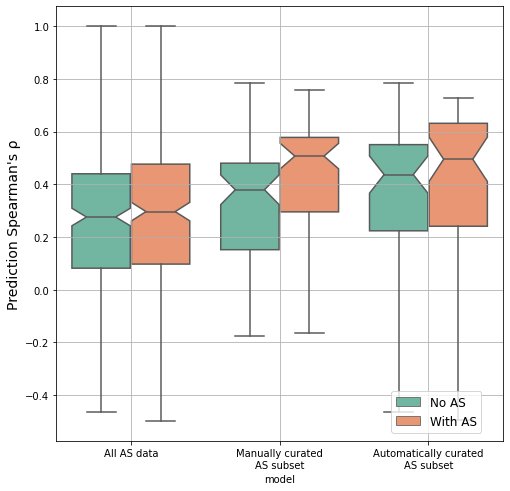

In [150]:
work_data = model_perform[~model_perform['Ascan_id'].isna()]
work_data = work_data.melt(id_vars=['dmsa_id', 'model'], value_vars=['No AS', 'With AS'], 
                           var_name='Feature', value_name='spear')

plt.figure(figsize=(8,8))
sns.boxplot(data=work_data.query("dmsa_id not in @one_residue_filter"), 
            x='model', y='spear', hue='Feature', palette='Set2', notch=True, whis=np.inf)
plt.grid()
plt.ylabel('Prediction Spearman\'s ρ', fontsize=14)
plt.legend(loc=[0.75,0.02], fontsize=12)
plt.show()

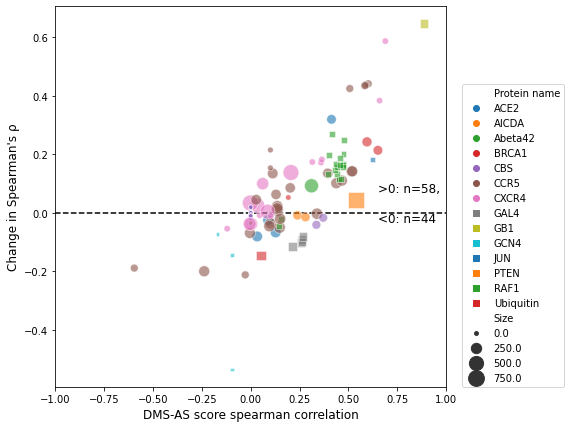

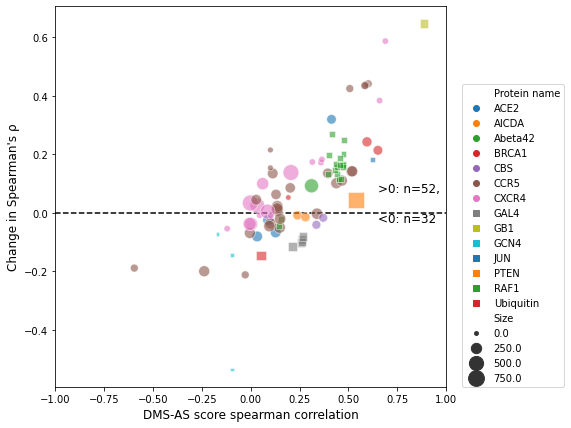

In [173]:
def foo_scatter(work_data):
    work_data.rename(columns={'protein_name':'Protein name', 'size':'Size'}, inplace=True)
    
    order = np.sort(work_data['Protein name'].unique())
    half = int(len(order)/2)
    markers = dict(zip(order, ['o']*half + ['s']*(len(order) - half)))

    fig, ax = plt.subplots(1, 1, figsize=(7,7))
    fig.patch.set_facecolor('w')
    g = sns.scatterplot(data=work_data, x='dmsa_corr', y='diff_spear', size='Size', hue='Protein name', hue_order=order,
                        style='Protein name', alpha=0.6, ax=ax, sizes=(15,250), palette="tab10", markers=markers)
    g.legend_.remove()
    ax.hlines(0, *[-1, 1], linestyles='--', colors='k', zorder=0)
    ax.text(0.65, -0.03, f">0: n={sum(work_data['diff_spear']>0)},\n\n<0: n={sum(work_data['diff_spear']<0)}", 
            fontsize=12)
    ax.set_xlim(-1, 1)
    ax.set_xlabel('DMS-AS score spearman correlation', fontsize=12)
    ax.set_ylabel('Change in Spearman\'s ρ', fontsize=12)
    plt.legend(loc=(1.04, 0))
    plt.show()
    

from scipy.stats import spearmanr
dmsa_corr = pd.Series(name='dmsa_corr')
for dmsa, df in dms_all_as.groupby('dmsa_id'):
    if dmsa[-3:] == 'nan':
        continue
    else:
        dmsa_corr[dmsa] = spearmanr(df['score'], df['AS_score'])[0]
# All AS scores are the same will cause NA value, which are imputed to 0.
dmsa_corr = dmsa_corr.fillna(0)

work_data = pd.merge(model_perform, dmsa_corr, how='inner', left_on='dmsa_id', right_index=True, 
                     validate='m:1')
foo_scatter(work_data.query("model == 'Manually curated\\nAS subset'"))
foo_scatter(work_data.query("model == 'Manually curated\\nAS subset' & dmsa_id not in @one_residue_filter"),)

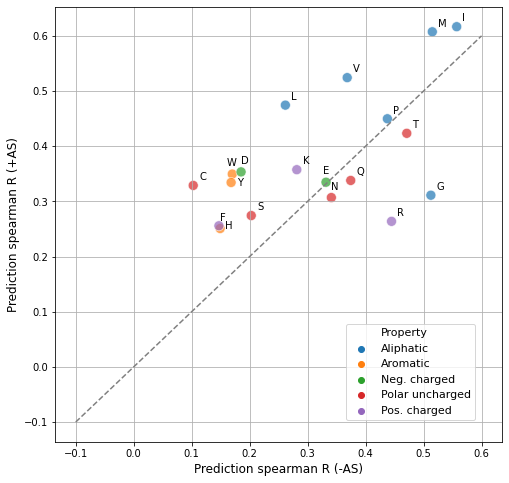

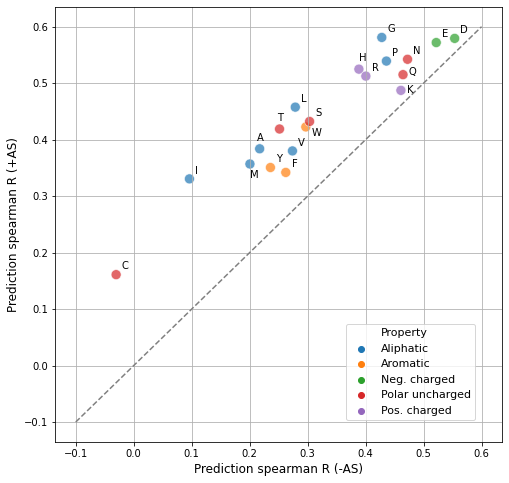

In [174]:
AA_PROPERTY = {
    "W": "Aromatic",
    "F": "Aromatic",
    "Y": "Aromatic",
    "P": "Aliphatic",
    "M": "Aliphatic",
    "I": "Aliphatic",
    "L": "Aliphatic",
    "V": "Aliphatic",
    "A": "Aliphatic",
    "G": "Aliphatic",
    "C": "Polar uncharged",
    "S": "Polar uncharged",
    "T": "Polar uncharged",
    "Q": "Polar uncharged",
    "N": "Polar uncharged",
    "D": "Neg. charged",
    "E": "Neg. charged",
    "H": "Pos. charged",
    "R": "Pos. charged",
    "K": "Pos. charged",
}


def foo_aa_type_spear(input_data, aa_type):
    work_data = input_data[input_data['dmsa_id'].str[-4:] != '@nan']
    aa_perf = pd.DataFrame()
    columns = ['pred_score_ala', 'pred_score_noala']
    index = []
    aa_perf = []
    for aa, df in work_data.groupby(aa_type, as_index=False):
        accuracy = []
        for model in columns:
            accuracy.append(spearmanr(df["ob_score"], df[model])[0])
        aa_perf.append(accuracy)
        index.append(aa)
    aa_perf = pd.DataFrame(aa_perf, columns=columns, index=index)
    aa_perf['aa'] = aa_perf.index
    aa_perf["aa_property"] = aa_perf["aa"].map(AA_PROPERTY)
    aa_perf['diff'] = aa_perf['pred_score_ala'] - aa_perf['pred_score_noala']
    return aa_perf.sort_values('aa_property')


def foo_scatter(vis_data, text_shift=dict()):
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    fig.patch.set_facecolor('w')
    foo = vis_data.copy()
    foo.rename(columns={'aa_property': 'Property'}, inplace=True)
    g = sns.scatterplot('pred_score_noala', 'pred_score_ala', data=foo, hue='Property', palette='tab10', s=100, alpha=0.7, ax=ax)
    for index, row in foo.iterrows():
        aa = row['aa']
        x_shift = text_shift.get(aa,[0.01,0.01])[0]
        y_shift = text_shift.get(aa,[0.01,0.01])[1]
        ax.text(row['pred_score_noala']+x_shift, row['pred_score_ala']+y_shift, aa)
    ax.legend(loc=[.65,0.05], fontsize=11)
    ax.plot([-0.1,0.6],[-0.1,0.6], '--', color='gray')
    ax.set_ylabel('Prediction spearman R (+AS)', fontsize=12)
    ax.set_xlabel('Prediction spearman R (-AS)', fontsize=12)
    ax.grid()
    plt.show()
    

work_data = pd.merge(mut_prediction['Manually curated\nAS subset'], dms_all_as[['dmsa_id', 'position', 'aa2', 'aa1']], 
                     how='left', on=['dmsa_id', 'position', 'aa2'], validate='m:1')
wt_perf = foo_aa_type_spear(work_data, 'aa1')
mt_perf = foo_aa_type_spear(work_data, 'aa2')
foo_scatter(wt_perf, {'E':[-0.005,0.015], 'N':[0,0.015], 'Y':[0.01,-0.005], 'H':[0.01,-0.005],
                      'F':[0,0.015], 'W':[-0.01,0.015], 'D':[0,0.015]})
foo_scatter(mt_perf, {'K':[0.01,-0.005], 'Q':[0.01,0], 'H':[0,0.015], 'W':[0.01,-0.015], 'M':[0,-0.025], 
                      'A':[-0.005,0.015], 'T':[-0.005,0.015]})

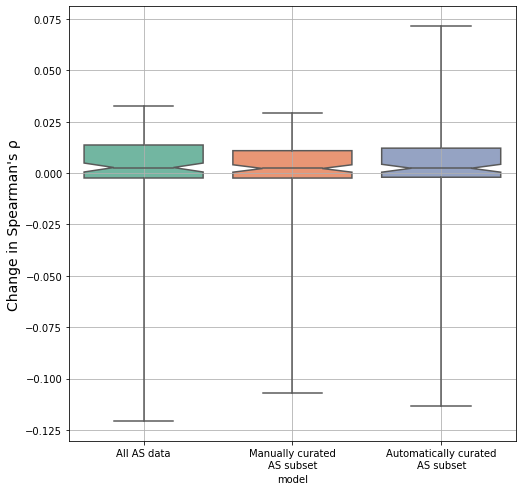

In [175]:
plt.figure(figsize=(8,8))
sns.boxplot(data=model_perform[model_perform['Ascan_id'].isna()], 
            x='model', y='diff_spear', palette='Set2', notch=True, whis=np.inf)
plt.ylabel('Change in Spearman\'s ρ', fontsize=14)
plt.grid()
plt.show()

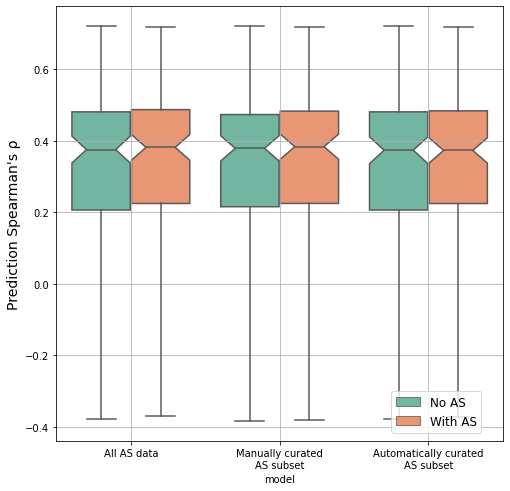

In [176]:
work_data = model_perform[model_perform['Ascan_id'].isna()]
work_data = work_data.melt(id_vars=['dmsa_id', 'model'], value_vars=['No AS', 'With AS'], 
                           var_name='Feature', value_name='spear')

plt.figure(figsize=(8,8))
sns.boxplot(data=work_data.query("dmsa_id not in @one_residue_filter"), 
            x='model', y='spear', hue='Feature', palette='Set2', notch=True, whis=np.inf)
plt.grid()
plt.ylabel('Prediction Spearman\'s ρ', fontsize=14)
plt.legend(loc=[0.75,0.02], fontsize=12)
plt.show()

In [177]:
work_data = dms_all_as[dms_all_as['Ascan_score_avail']].query("aa2 == 'A'")

In [178]:
work_data

,dms_id,position,entropy,log2f_var,matrix,score,sub_type,u_pos,uniprot_id,Ascan_id,...,aa2_Q,aa2_R,aa2_S,aa2_T,aa2_V,aa2_W,aa2_Y,aa1,aa2,weight
1993,Brca1_E3,26.0,0.2356,-19.8269,-0.2963,0.747224,IA,26.0,P38398,brca1_mono_ub,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,I,A,0.1
1994,Brca1_E3,26.0,0.2356,-19.8269,-0.2963,0.747224,IA,26.0,P38398,brca1_myc,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,I,A,0.1
1995,Brca1_Y2H,26.0,0.2356,-19.8269,-0.2963,1.033306,IA,26.0,P38398,brca1_mono_ub,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,I,A,0.1
1996,Brca1_Y2H,26.0,0.2356,-19.8269,-0.2963,1.033306,IA,26.0,P38398,brca1_myc,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,I,A,0.1
1997,brca1-starita2018,26.0,0.2356,-19.8269,-0.2963,0.972456,IA,26.0,P38398,brca1_mono_ub,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,I,A,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352556,urn:mavedb:00000054-a-1,131.0,0.0611,-8.8916,-0.1608,0.615962,TA,131.0,P60484,pten,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T,A,1.0
352863,urn:mavedb:00000054-a-1,161.0,3.0545,-7.8917,-0.2748,0.735020,RA,161.0,P60484,pten,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,R,A,1.0
352913,urn:mavedb:00000054-a-1,166.0,0.1853,-22.1734,-0.1977,0.685678,VA,166.0,P60484,pten,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,V,A,1.0
352925,urn:mavedb:00000054-a-1,168.0,0.2745,-22.1704,-0.2963,0.977663,IA,168.0,P60484,pten,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,I,A,1.0
